In [2]:
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import StatePreparation, QFT
from qiskit_aer import AerSimulator
import cvxpy as cp
from pyqsp import angle_sequence
from numpy.polynomial.chebyshev import chebpts1, Chebyshev

In [11]:
""" 
Requirements: cvxpy, pyqsp (install with pip)

Functions: cvx_poly_coef, Angles_symQSP

cvx_poly_coef uses the cvxpy convex optimizer to find the Chebyshev polynomial best approximating
a given target function. 

Angles_symQSP uses the pyqsp implementation of qsp_sym to find an optimal angle sequence for a
given Chebyshev coefficient sequence. 
"""  

def cvx_poly_coef(targ_f, interval, deg, epsil = 1e-5, npts=200, plot=False):
    """
    targ_f: target function to be approximated. Should be odd or even and bounded by 1 on interval.
    interval: of the form [a,b] contained in [0,1].
    deg: degree of polynomial approximation.
    epsil: Desired error treshold. The resulting error tends to be much better provided the target function
           is bounded away from 1,-1 on the interval. 
    npts: number of Chebyshev points used in the optimizations.
    plot: If True, the obtained approximation is plotted against the target function and the maximal error
          is printed. 
    
    Returns: Array coef_full of consisting of the Chebyshev coefficients of the computed approximation.
            The length is deg+1
    """

    objnorm = np.inf
    parity = deg % 2

    # Generate Chebyshev points
    a, b = interval
    xpts = 0.5 * (a + b) + 0.5 * (b - a) * chebpts1(2 * npts)    # maps [-1,1] onto [a,b]
    npts = len(xpts)

    # Prepare Chebyshev polynomials
    n_coef = int(np.floor(deg/2)+1)

    Ax = np.zeros((npts, n_coef))
    for k in range(1,n_coef+1):
        Tcheb = Chebyshev.basis(2*(k-1)+parity)
        Ax[:,k-1] = Tcheb(xpts)

    # Use CVXPY to optimize coefficients
    coef = cp.Variable(n_coef)
    y = cp.Variable(npts)

    constraints = [
        y == Ax @ coef,
        y >= -(1 - epsil),
        y <= (1 - epsil),
    ]
    objective = cp.Minimize(cp.norm(y - targ_f(xpts), objnorm))
    problem = cp.Problem(objective, constraints)
    problem.solve()

    c = np.array(coef.value)  # Optimal coefficients

    coef_full = np.zeros(deg + 1)
    if parity == 0:
        coef_full[::2] = c
    else:
        coef_full[1::2] = c
    
    if plot:
        # Create the Chebyshev polynomial using these coefficients
        cheb_poly = Chebyshev(coef_full)
    
        # Checking max error
        x_data = np.linspace(a,b,2*npts)
        targ_val = targ_f(x_data)
        cheb_val = cheb_poly(x_data)
        abs_err = max(abs(targ_f(x_data)-cheb_poly(x_data)))
        print('The maximal error is:',abs_err)

        # Plot the results
        plt.figure(figsize=(10, 6))

        # Plot the original function
        plt.plot(x_data, targ_val, label="Original Function", color='blue', linestyle='dashed')

        # Plot the Chebyshev polynomial approximation
        plt.plot(x_data, cheb_val, label="Chebyshev Approximation", color='red')

        plt.xlabel('x')
        plt.ylabel('y')
        plt.legend()
        plt.show()

    return coef_full
    
def Angles_symQSP(coef,resp_plot = False,targ_f=None,QSVT_format = True):
    """
    Takes an array of Chebyshev coefficients as input and returns the QSVT angle sequence.
    If resp_plot = True, angle response is plotted against the input polynomial. 
    """

    (phiset, red_phiset, parity) = angle_sequence.QuantumSignalProcessingPhases(
        poly=coef,
        eps=1e-6,
        suc=1 - 1e-6,
        signal_operator="Wx",
        measurement=None,
        tolerance=0.01,
        method="sym_qsp",
        chebyshev_basis=True
    )

    # Plot response
    if resp_plot and targ_f:
        response.PlotQSPResponse(
            phiset,
            target=targ_f,
            signal_operator="Wx",
            measurement="z",
            sym_qsp=True,
            simul_error_plot=True,
            title="Comparison"
        )
    
    if QSVT_format:
        n = len(phiset)-1
        Phi = np.zeros(n)
        Phi[1:n] = phiset[1:n]-np.pi/2
        Phi[0] = phiset[0]+phiset[-1]+((n-2)%4)*np.pi/2
        # In the ususal QSP to QSVT one adds (n-1) pi/2. Here (n-2) is needed. 
        # In the symmetric qsp protocol the target polynomial is encoded as Im P wrt. the standard pair (P,Q)
        # where the symmetry forces Q = Q* to be real. In my previous work the target function is Re P instead
        # and in that case one uses n-1 instead. 
    else: 
        Phi = phiset 
    return Phi

In [12]:
def diffusion_block_encoding(n_qubits):
    """
    Block Encoding encoding for the Diffusion Matrix A
    Tridiagonal elements: (1, -2, 1)
    Normalized: A/4
    """
    
    # REGISTERS
    # Ancilla (2 qubits): To encode the 3 diagonals
    # Main (n qubits): To encode the grid points (N = 2^n)
    anc = QuantumRegister(2, 'anc') 
    main = QuantumRegister(n_qubits, 'main')
    qc = QuantumCircuit(anc, main)

    # G_prep gate (State Preparation)
    coeffs = [0.5, np.sqrt(0.5), 0.5, 0.0]  # note: A is normalized
    prep_gate = StatePreparation(coeffs)

    prep_gate.label = "G_prep"
    qc.append(prep_gate, anc)
    
    # The diagonal elements (encoded in |01>) need to take a minus sign
    # Applying Z to anc[0] flips the phase of |01> (and |11>), but leaves |00> and |10> alone
    qc.z(anc[0])

    # Now we move to Fourier space where Addition = A specific Phase Rotation (to every qubit based on its "significance" (power of 2))
    # angle formula: angle_j = 2 pi k / N with:
    #   - k = 2^0 + 2^1 + ... + 2^(number of qubits - 1)
    #   - N = 2^(number of qubits)
    qft_gate = QFT(n_qubits, do_swaps=False).to_gate()
    qc.append(qft_gate, main)    # Note: do_swaps = False reverses Qiskit's default bit order to match math notation:
    # main[0] is now the MSB, and main[n_qubits-1] is the LSB.

    # CONTROLLED ADDITION (ModAdd)
    # Ancilla |00> (0): Add 0
    # Ancilla |01> (1): Add 1
    # Ancilla |10> (2): Add 2

    # Controlled-Add 1 (Controlled by anc[0], bit value 1)
    for i in range(n_qubits):
        angle = 2 * np.pi / (2**(i + 1))
        qc.cp(angle, anc[0], main[i])

    # Controlled-Add 2 (Controlled by anc[1], bit value 2)
    # Adding 2 is just doubling the angle of Adding 1.
    for i in range(n_qubits):
        angle = 4 * np.pi / (2**(i + 1))
        qc.cp(angle, anc[1], main[i])

    # We apply a global -1 shift: |x> -> |x-1>
    for i in range(n_qubits):
        angle = -2 * np.pi / (2**(1 + i))
        qc.p(angle, main[i])

    # Go back to Comp. Basis
    iqft_gate = QFT(n_qubits, inverse=True, do_swaps=False).to_gate()
    qc.append(iqft_gate, main)

    # --- 5. Uncompute G_prep (Inverse) ---
    # This projects the linear combination back onto the |00> subspace.
    qc.append(prep_gate.inverse(), anc)

    return qc

C:\Users\jmarq\AppData\Local\Temp\ipykernel_20960\2644605680.py:30: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  qft_gate = QFT(n_qubits, do_swaps=False).to_gate()
C:\Users\jmarq\AppData\Local\Temp\ipykernel_20960\2644605680.py:56: DeprecationWarning: The class ``qiskit.circuit.library.basis_change.qft.QFT`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. ('Use qiskit.circuit.library.QFTGate or qiskit.synthesis.qft.synth_qft_full instead, for access to all previous arguments.',)
  iqft_gate = QFT(n_qubits, inverse=True, do_swaps=False).to_gate()


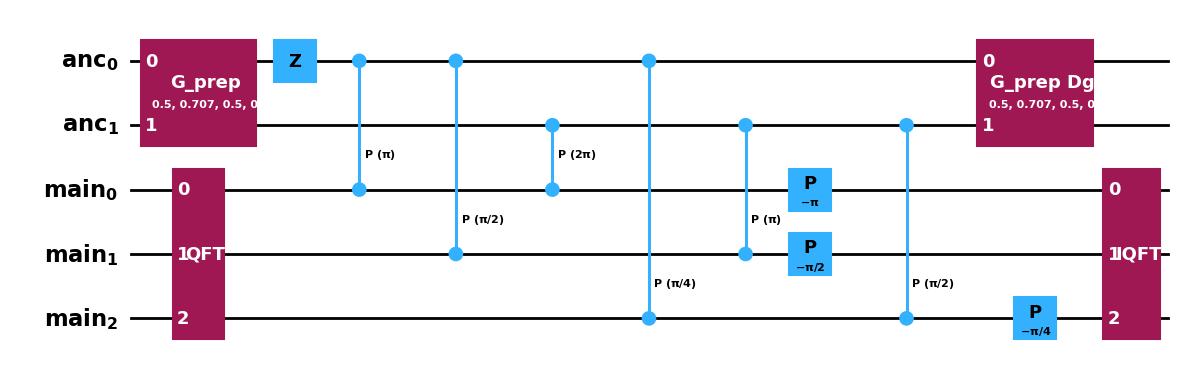

In [13]:
diffusion_block_encoding(3).draw('mpl')

In [14]:
def qsvt_circuit(n_qubits, phi_list):
    """
    QSVT circuit.
    Order: H, U -> [Pi-Rot-Pi] -> U_dag -> [Pi-Rot-Pi] -> U -> ...
    """
    
    # Registers
    sig = QuantumRegister(1, 'sig')
    anc = QuantumRegister(2, 'anc')
    main = QuantumRegister(n_qubits, 'main')
    qc = QuantumCircuit(sig, anc, main)
    
    # Pre-compute Operators
    U_circ = diffusion_block_encoding(n_qubits)
    U_gate = U_circ.to_gate(label="U")
    U_dag_gate = U_circ.inverse().to_gate(label="U†")
    
    # --- STEP 1: INITIALIZATION ---
    qc.h(sig)                   # H on Signal
    qc.append(U_gate, anc[:] + main[:]) # U on System (Diagram Start)
    
    # --- STEP 2: THE LOOP (Right to Left in diagram means d down to 1) ---
    # The diagram applies phi_d first, then U_dagger, then phi_{d-1}, then U...
    
    # We loop k from 0 to d-1. 
    # phi_list is usually [phi_0, phi_1, ..., phi_d]. 
    # Note: Standard QSP often lists phases 0 to d. 
    # We will assume phi_list matches the sequence needed: [phi_d, phi_d-1, ..., phi_1].
    # If passing raw pyqsp output, verify indexing. Assuming list is ordered [phi_d, ..., phi_1].
    
    num_phases = len(phi_list)
    
    for k, phi in enumerate(phi_list):
        # A. THE PI-ROTATION-PI SANDWICH
        # 1. First Pi-Control (Project on |00>)
        qc.x(anc)
        qc.mcx(anc, sig)
        qc.x(anc)
        
        # 2. Rotation (Theta = 2*phi)
        qc.rz(2 * phi, sig)
        
        # 3. Second Pi-Control
        qc.x(anc)
        qc.mcx(anc, sig)
        qc.x(anc)
        
        # B. INTERLEAVED OPERATOR
        # We apply an operator AFTER every sandwich EXCEPT the very last one.
        if k < num_phases - 1:
            if k % 2 == 0:
                # After phi_d (k=0), diagram shows U_dagger
                qc.append(U_dag_gate, anc[:] + main[:])
            else:
                # After phi_{d-1} (k=1), diagram shows U
                qc.append(U_gate, anc[:] + main[:])
                
    # --- STEP 3: FINALIZATION ---
    qc.h(sig)
    
    return qc

In [17]:
def get_diffusion_phis(t, nu, n_qubits, degree=50):
    """Calculates effective tau and returns QSVT angles."""
    
    # 1. Scaling
    dx = 1.0 / (2**n_qubits)
    # The block encoding is A_norm = A_grid / 4.
    # We want exp(A_grid * t). 
    # exp(A_grid * t) = exp(4 * A_norm * t * (nu / dx^2))
    # Wait! The matrix M in the PDF is (nu/dx^2)*A. 
    # So u(t) = exp(M t) = exp( (nu/dx^2) * A * t ).
    # Block encoding gives A/4. So we substitute A = 4 * A_block.
    # Result: exp( (4 * nu * t / dx^2) * A_block ).
    tau_eff = (4 * nu * t) / (dx**2)
    
    print(f"DEBUG: Effective Tau = {tau_eff:.4f}")

    # 2. Target Function (Parity Fix)
    # Target: exp(-tau * |x|) to ensure EVEN parity.
    #target_f = lambda x: np.exp(-tau_eff * np.abs(x))
    target_f = lambda x: np.sin(tau_eff * x)  # ODD function for diffusion example
    
    # 3. Get Coefficients
    # Must be even degree
    if degree % 2 != 0: degree += 1
    
    coeffs = cvx_poly_coef(
        targ_f=target_f,
        interval=[-1, 1], 
        deg=degree,
        plot=False
    )
    
    # 4. Get Angles
    phis = Angles_symQSP(coeffs)
    return phis

# --- 4. MAIN SIMULATION ---

def run_simulation():
    # Parameters
    n_qubits = 10   # Grid size 2^4 = 16
    nu = 0.02      # Diffusion coefficient
    t_target = 0.1 # Time to simulate
    
    # 1. Get Angles
    print("Computing angles...")
    # Note: High degree needed if tau is large!
    phis = get_diffusion_phis(t_target, nu, n_qubits, degree=50) 
    
    # 2. Build QSVT Circuit
    print("Building circuit...")
    qsvt_qc = qsvt_circuit(n_qubits, phis)
    
    # 3. Add Initial Condition |u_0>
    # Let's use the Gaussian example from the PDF: u_0(x) = e^{-10(x-0.5)^2}
    # We need to prepare this state on the 'main' register BEFORE the QSVT.
    grid = np.linspace(0, 1, 2**n_qubits, endpoint=False)
    u0_vals = np.exp(-100 * (grid - 0.5)**2) # Sharper gaussian
    u0_norm = u0_vals / np.linalg.norm(u0_vals)
    
    full_qc = QuantumCircuit(qsvt_qc.qubits)
    
    # Initialize 'main' register
    # Note: qubits in qsvt_qc are ordered [sig, anc0, anc1, main0...mainN]
    main_qubits = full_qc.qubits[3:] 
    
    init_gate = StatePreparation(u0_norm)
    full_qc.append(init_gate, main_qubits)
    
    # Append the QSVT operation
    full_qc.compose(qsvt_qc, inplace=True)
    
    # 4. Run Simulation (Statevector)
    print("Simulating...")
    backend = AerSimulator(method='statevector')
    # Save statevector to extract amplitudes directly
    full_qc.save_statevector()
    transpiled_qc = transpile(full_qc, backend)
    result = backend.run(transpiled_qc).result()
    statevector = result.get_statevector()
    
    # --- 5. POST-SELECTION & EXTRACTION ---
    # We need the part of the vector where:
    # Signal (qubit 0) == |0>
    # Ancilla (qubits 1,2) == |00>
    
    # Qiskit Statevector ordering is Little Endian: |qN ... q0>
    # But indices in the vector correspond to binary integer representations.
    # We want indices where lowest 3 bits are 000.
    
    n_total = full_qc.num_qubits
    sv_array = np.asarray(statevector)
    
    # Create mask for valid indices
    # We want indices i such that (i & 7) == 0  (binary ...000)
    valid_indices = [i for i in range(len(sv_array)) if (i & 0b111) == 0]
    
    # Extract the 'main' register state
    final_state_raw = sv_array[valid_indices]
    
    # Compute Probability of Success (Norm of this slice)
    p_success = np.linalg.norm(final_state_raw)**2
    print(f"Success Probability: {p_success:.4f}")
    
    if p_success < 1e-6:
        print("Signal too weak! Try reducing time step or improving poly.")
        return

    # Normalize to get the physical solution vector
    u_final_quantum = final_state_raw / np.linalg.norm(final_state_raw)
    
    # Match sign with initial condition (Global phase fix)
    # The quantum state might have a global -1 phase relative to classical.
    if np.sign(u_final_quantum[np.argmax(np.abs(u_final_quantum))]) != \
       np.sign(u0_norm[np.argmax(np.abs(u0_norm))]):
        u_final_quantum *= -1
        
    # --- 6. COMPARE WITH CLASSICAL EXACT SOLUTION ---
    # Classical diffusion is convolution with heat kernel, 
    # or simply decay in Fourier space.
    # FFT -> Decay -> IFFT
    
    u0_fft = np.fft.fft(u0_norm)
    # Wavenumbers k for periodic boundaries
    k = np.fft.fftfreq(2**n_qubits, d=1.0/(2**n_qubits))
    # Decay factor: exp(-4 * pi^2 * nu * k^2 * t)
    # Note: The PDF exact solution (Eq 6) uses specific constants.
    # Simplified Fourier decay:
    decay = np.exp(-4 * np.pi**2 * nu * k**2 * t_target)
    
    u_final_classical_fft = u0_fft * decay
    u_final_classical = np.real(np.fft.ifft(u_final_classical_fft))
    u_final_classical /= np.linalg.norm(u_final_classical) # Normalize for comparison

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(grid, u0_norm, 'k--', label="Initial Condition (t=0)", alpha=0.5)
    plt.plot(grid, u_final_classical, 'b-', linewidth=2, label="Classical Exact (t=0.5)")
    plt.plot(grid, np.real(u_final_quantum), 'r*', markersize=8, label="QSVT Solution (t=0.5)")
    plt.title(f"Quantum Fluid Simulation (N={2**n_qubits}, t={t_target})")
    plt.xlabel("Position x")
    plt.ylabel("Amplitude u(x)")
    plt.legend()
    plt.grid(True)
    plt.show()


In [18]:
run_simulation()

Computing angles...
DEBUG: Effective Tau = 8388.6080


AngleFindingError: Polynomial must have definite parity and be non-zero: [-4.78003596e-11  0.00000000e+00  2.82098034e-11  0.00000000e+00
  1.61948112e-11  0.00000000e+00 -1.23687362e-11  0.00000000e+00
 -2.19734097e-11  0.00000000e+00  1.61072232e-11  0.00000000e+00
  4.00650661e-11  0.00000000e+00 -5.09837189e-12  0.00000000e+00
 -2.18521732e-11  0.00000000e+00  2.92393914e-11  0.00000000e+00
 -3.42020547e-11  0.00000000e+00 -1.57347243e-13  0.00000000e+00
  9.49127823e-13  0.00000000e+00 -1.04330889e-11  0.00000000e+00
 -6.75526401e-12  0.00000000e+00 -6.67634623e-12  0.00000000e+00
  3.79066710e-11  0.00000000e+00  2.68064399e-12  0.00000000e+00
 -1.95495772e-11  0.00000000e+00  2.79618644e-11  0.00000000e+00
  2.46444916e-11  0.00000000e+00 -2.92264852e-11  0.00000000e+00
 -6.10647870e-12  0.00000000e+00 -1.24286592e-11  0.00000000e+00
  2.98435175e-11  0.00000000e+00 -3.82592127e-11]